# Question 1

Q 1.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mltools as ml

data = np.genfromtxt("data/curve80.txt",delimiter=None)
X = data[:,0]
X = np.atleast_2d(X).T  # code expects shape (M,N) so make sure it's 2-dimensional
Y = data[:,1]
Xtr,Xte,Ytr,Yte = ml.splitData(X,Y,0.75)  # split data set 75/25
print("Shape of Xtr: ", Xtr.shape)
print("Shape of Xte: ", Xte.shape)
print("Shape of Ytr: ", Ytr.shape)
print("Shape of Yte: ", Yte.shape)

Shape of Xtr:  (60, 1)
Shape of Xte:  (20, 1)
Shape of Ytr:  (60,)
Shape of Yte:  (20,)


Q 1.2

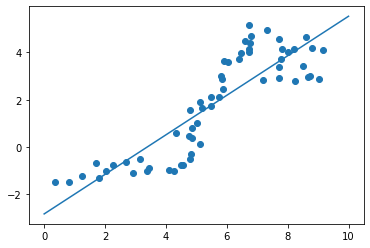

Linear Regression Coefficients:  [[-2.82765049  0.83606916]]
MSE on training data:  1.127711955609391
MSE on test data:  2.2423492030101246


In [2]:
lr = ml.linear.linearRegress( Xtr, Ytr )  # create and train model
xs = np.linspace(0,10,200)     # densely sample possible x-values
xs = xs[:,np.newaxis]          # force "xs" to be an Mx1 matrix (expected by our code)
ys = lr.predict( xs )          # make predictions at xs

plt.scatter(Xtr,Ytr)
plt.plot(xs,ys)
plt.show()

# Linear Regression Coefficients
print("Linear Regression Coefficients: ", lr.theta)
# From the result we know that theta0 = -2.82765049 and theta1 = 0.83606916
# The prediction function is: y^(x) = -2.82765049 + 0.83606916x_1
# By finding points on the line, we can verify that the coefficients we get are correct

# Mean squared error of the predictions on the training data
print("MSE on training data: ", lr.mse(Xtr, Ytr))

# Mean squared error of the predictions on the test data
print("MSE on test data: ", lr.mse(Xte, Yte))

Q 1.3

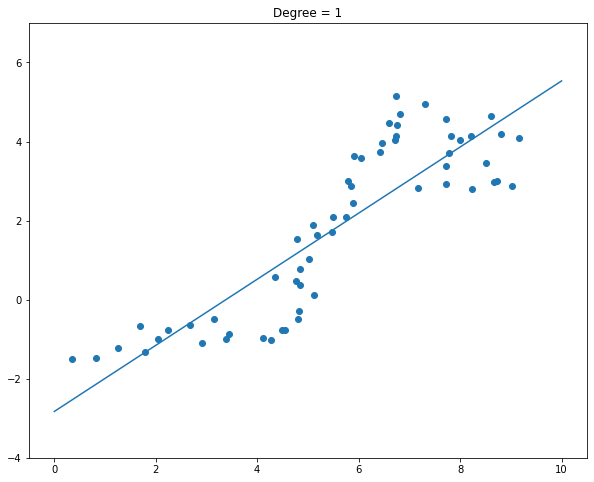

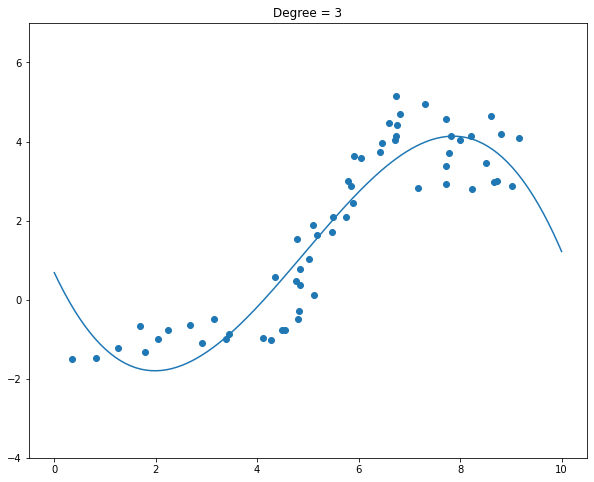

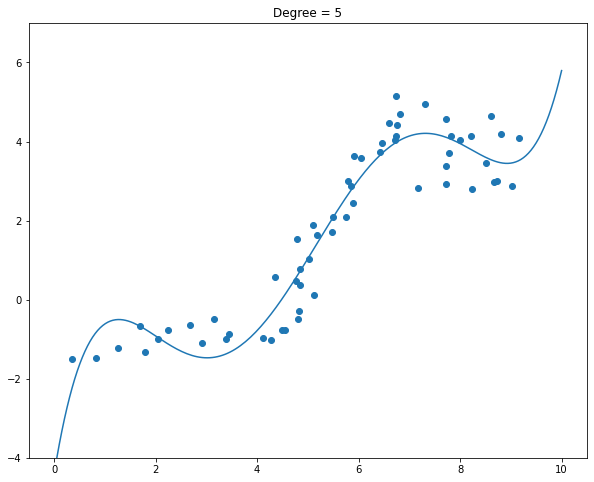

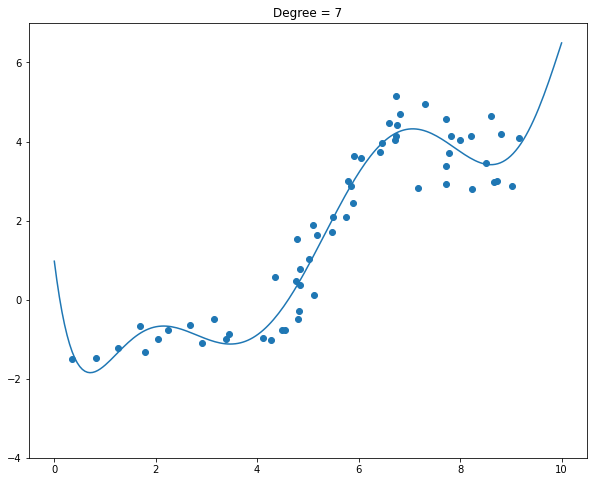

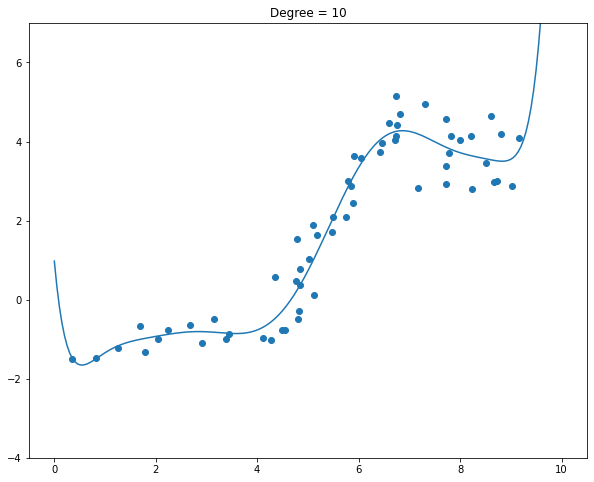

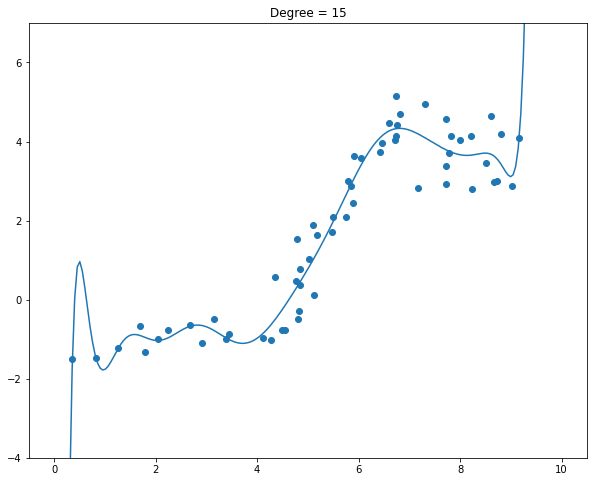

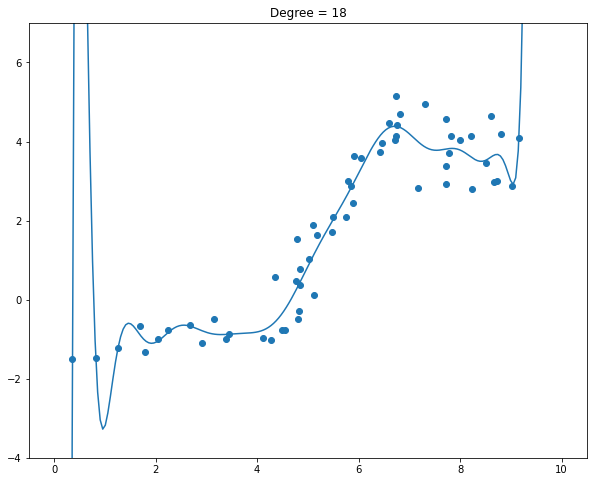

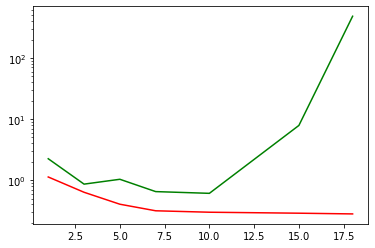

In [3]:
degrees = [1, 3, 5, 7, 10, 15, 18]
testMse = []
trainMse = []
for degree in degrees:
    # Create polynomial features up to "degree"; don't create constant feature
    # (the linear regression learner will add the constant feature automatically)
    XtrP = ml.transforms.fpoly(Xtr, degree, bias=False)
    
    # Rescale the data matrix so that the features have similar ranges / variance
    XtrP,params = ml.transforms.rescale(XtrP)
    # "params" returns the transformation parameters (shift & scale)

    # Then we can train the model on the scaled feature matrix:
    lr = ml.linear.linearRegress( XtrP, Ytr ) # create and train model

    # Now, apply the same polynomial expansion & scaling transformation to Xtest:
    XteP,_ = ml.transforms.rescale( ml.transforms.fpoly(Xte,degree,False), params)
    
    xsP,_ = ml.transforms.rescale(ml.transforms.fpoly(xs,degree,False), params)
    ys = lr.predict(xsP)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8)) # Create axes for single subplot
    plt.scatter(Xtr,Ytr)
    ax.plot(xs, ys) # Plot polynomial regression of desired degree
    ax.set_ylim(-4, 7) # Set the minimum and maximum limits
    plt.title("Degree = " + str(degree))
    plt.show()
    
    trainMse.append(lr.mse(XtrP, Ytr))
    testMse.append(lr.mse(XteP, Yte))
    
plt.semilogy(degrees, trainMse, "r")
plt.semilogy(degrees, testMse, "g")
plt.show()

According to the graph above, I recommend degree at 10.

Q 1.4 (Extra)

In [4]:
XtrF = np.zeros( (Xtr.shape[0],5) ) # create Mx5 array to store features
# [[0. 0. 0. 0. 0.]]
XtrF[:,0] = Xtr[:,0] # place original "x" feature as X1
XtrF[:,1] = np.sin(Xtr[:,0]/2.) # place "sin(x)" feature as X2 (approx. scaled to X's range)
XtrF[:,2] = np.cos(Xtr[:,0]/2.) # place "cos(x)" feature as X3
XtrF[:,3] = np.sin(Xtr[:,0]*2./2.) # place "sin(2*x)" feature as X3
XtrF[:,4] = np.cos(Xtr[:,0]*2./2.) # place "cos(2*x)" feature as X4
# Now, XtrF has five features about each data point: "x" and four Fourier features

degrees = [1, 3, 5, 7, 10, 15, 18]
testMse = []
trainMse = []
for degree in degrees:
    XtrFP = ml.transforms.fpoly(XtrF, degree, bias=False)
    XtrFP,params = ml.transforms.rescale(XtrFP)
    lr = ml.linear.linearRegress( XtrFP, Ytr )
    XteP,_ = ml.transforms.rescale( ml.transforms.fpoly(Xte,degree,False), params)
    xsP,_ = ml.transforms.rescale(ml.transforms.fpoly(xs,degree,False), params)
    ys = lr.predict(xsP)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    plt.scatter(Xtr,Ytr)
    ax.plot(xs, ys)
    ax.set_ylim(-4, 7)
    plt.show()
    
    trainMse.append(lr.mse(XtrFP, Ytr))
    testMse.append(lr.mse(XteP, Yte))
    
plt.semilogy(degrees, trainMse, "r")
plt.semilogy(degrees, testMse, "g")
plt.show()

# Question 2

Q 2.1

In [5]:
def calMse(degree, nFolds):
    J = [0] * nFolds
    for iFold in range(nFolds):
        Xti,Xvi,Yti,Yvi = ml.crossValidate(Xtr,Ytr,nFolds,iFold) # use ith block as validation
        XtiP = ml.transforms.fpoly(Xti,degree,bias=False)
        XtiP,params = ml.transforms.rescale(XtiP)
        learner = ml.linear.linearRegress(XtiP, Yti) # TODO: train on Xti, Yti, the data for this fold
        XviP,_ = ml.transforms.rescale(ml.transforms.fpoly(Xvi,degree,False), params)
        J[iFold] = learner.mse(XviP, Yvi) # TODO: now compute the MSE on Xvi, Yvi and save it
    # the overall estimated validation error is the average of the error on each fold
    
    # Update globally defined lists
    cvMse.append(np.mean(J))

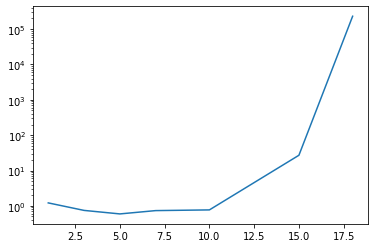

In [6]:
degrees = [1, 3, 5, 7, 10, 15, 18]
cvMse = []
for degree in degrees:
    calMse(degree, 5)
    
plt.semilogy(degrees, cvMse)
plt.show()

Q 2.2

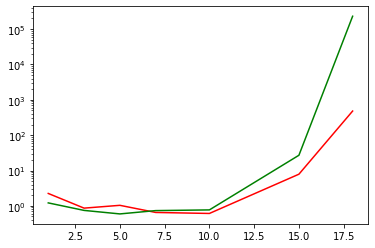

In [7]:
plt.semilogy(degrees, testMse, "r") # MSE from cross-validation
plt.semilogy(degrees, cvMse, "g") # MSE from test data
plt.show()

There are not huge differences between the MSE estimates from five-fold cross-validation and the MSEs evaluated on the actual test data, except that the recommended degree is different (one is 10 and one is 5).

Q 2.3

According to the graph above, I recommend degree at 5.

Q 2.4

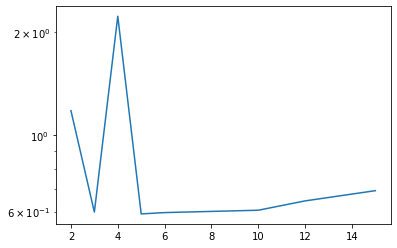

In [8]:
nFolds = [2, 3, 4, 5, 6, 10, 12, 15]
cvMse = []
for nFold in nFolds:
    calMse(5, nFold)
    
plt.semilogy(nFolds, cvMse)
plt.show()

From the graph above, we can see that the cross-validation error can be fluctuate and unstable when nFold is small, and it becomes flat when nFold gets big. The reason can be that the pattern we define when nFold is low tend to be extreme (not a correct general pattern) so that the testing data could either all fit or hardly fit the pattern. As we increase nFold, the pattern we define becomes more general and can fit most of our test data.

# Question 3

For this homework, I relied mainly on sample code in the discussion. I also post some questions on piazza and get the clarification of concepts and homework requirements. I did not collaborate with any other student.